Deep learning has made significant breakthrough in the past decade. Various novel applications has been developed and achieved good performance by leveraging the latest advances in deep learning. In this paper, we propose to utilize deep learning based technique, specifically, Convolutional Neural Network (CNN) using keras and Region based Convolutional Neural Network(R-CNN) using Tensorflow Object Detection API, to develop an auto-counting system for items stored in the refrigerator.Given a picture of the refrigerator, the system can automatically detect the specified categories of refrigerated items and give their respective counts. To achieve the result, we implemented transfer learning on pre-trained model called Region - Based Fully Convolutional Network (RFCN) using Tensorflow Object Detection API for localizing different grocery objects. The dataset that was used for implementing this has been web scraped and labelled using the graphical image annotation tool- Labelimg and given as an input to this tweaked pre trained model.The accuracy achieved using the resnet 101 layer model which is used by RFCN gives dependable results. Experimental results on our dataset confirm that RFCN has comparable accuracy to methods that use multiple costly per-region subnetwork hundreds of times (fast RCNN and faster RCNN)  in contrast to the computation shared on the entire image. 

# Installation Instructions

Image Classification is done using [keras](https://keras.io/) framework. Before installing Keras we have to install one of its backend engines from : Tensorflow, Theano or CNTK

Steps for Keras Installation


1. [Tensorflow installation instruction](https://www.tensorflow.org/install/) -- Backend of keras

Setup your python environment and enter the command
2. <i>pip install keras</i>

in your terminal window


We now create the model for performing Image Classification and to do that we import the following libraries.

In [8]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, optimizers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import sys
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import HTML

## Creating  a Model

We now build our model for Image Classification. As our dataset is small with approx 500 images we create 2 network layer, 1 fully connected layer and Output layer. To avoid the problem of over fitting of the images, we added the dropout layer to the network layer.

The use of each of the layer is:
1. Input layer : This is the first layer of a neural network. It is used to provide the input data or features to the network
2. Network Layer : This layer basically takes an input volume (whatever the output is of the conv or ReLU or pool layer preceding it) and outputs an N dimensional vector where N is the number of classes that the program has to choose from
3. Output Layer : The way this fully connected layer works is that it looks at the output of the previous layer (which as we remember should represent the activation maps of high level features) and determines which features most correlate to a particular class

In the createModel method, we pass the activation function, loss function and optimizer as an input parameter because we will be doing [hyperparameter tunning](#another_cell) to decide which activation function, loss function and optimizers gives us higher accuracy



In [3]:
def createModel(activationFunc, lossFunction, optimizer):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(100, 100,3), activation = activationFunc))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), activation = activationFunc))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation = activationFunc))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units = 128, activation = activationFunc))
    model.add(Dropout(0.5))

    model.add(Dense(units = 9, activation = 'softmax'))
    
    model.compile(loss=lossFunction, optimizer=optimizer, metrics=['accuracy'])
    return model

Before we train the model, all the input images are augmented via number of random transformation so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. We are achieving this by using keras.preprocessing.image.ImageDataGenerator. 

In [4]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/train',
        target_size=(100, 100), 
        batch_size=batch_size,
        class_mode='categorical') 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory('data/validation',
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')

Found 4361 images belonging to 9 classes.
Found 1460 images belonging to 9 classes.


We fit the created model on the training data. While fitting the model, we provide training data, steps_per_epoch, epochs, validation data and validation steps

1. steps_per_epoch: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
2. validation_steps:  relevant if steps_per_epoch is specified. Total number of steps (batches of samples) to validate before stopping.
3. epochs : Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.
4. train_generator : No of images in the training dataset
5. validation_generator: No of images in validation dataset.

In [5]:
#fitting the model on training data
def model_fit(epochs):
    model.fit_generator(train_generator,
            steps_per_epoch=4361 // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=1460 // batch_size)

## Testing a model

In [6]:
def testModel():
    
    imageId = 0
    appleCount = 0
    bananCount = 0
    apricotCount = 0

    fig=plt.figure()

    for i in range(12):

        y = fig.add_subplot(3,4,i+1)

        path = "data/single_prediction/" + str(imageId) + "_100.jpg"
        imageId += 1 
        test_image = image.load_img(path, target_size = (100, 100))
        test_image = image.img_to_array(test_image)

        orig = test_image/255
        orig_1 = orig

        test_image = np.expand_dims(test_image, axis = 0)    
        result = model.predict(test_image)
        #print(result[0])
        train_generator.class_indices

        if result[0][0] or result[0][1] or result[0][2] or result[0][3] or result[0][4] or result[0][5] or result[0][6] == 1:
            str_label = 'Apple'
            appleCount += 1
        elif result[0][7] == 1:
            str_label = 'Apricot'
            apricotCount += 1
        else:
            str_label = 'Banana'
            bananCount += 1

        y.imshow(orig_1)
        plt.title(str_label)
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
    plt.show()

<a id='another_cell'></a>
## Hyperparameter Tunning

Hyperparameter tunning typically address the problem of how to choose the next hyperparameter values so that model gives the higher accuracy. we briefly survey the hyperparameters for convnet

1. Number of epochs: Number of epochs is the the number of times the entire training set pass through the neural network. We should increase the number of epochs until we see a small gap between the test error and the training error

2. Batch Size: Mini-batch is usually preferable in the learning process of convnet. A range of 16 to 128 is a good choice to test with. We should note that convnet is sensitive to batch size.

3. Activation function: Activation funtion introduces non-linearity to the model. Usually, relu works well with convnet. Other alternatives are sigmoid, tanh and other activation functions depening on the task 

## Training Model

We now train the model for different values of hyperparameters like activation function, optimizer and no of epochs. 
1. Possible values of optimizer is:['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']. Out of the possible values we will be using optimizers like 'rmsprop', 'adam' and 'sgd' for training and testing our model
2. Possible values of activation function is : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']. Out of all the possible values of activation function we will be using 'relu', 'tanh','sigmoid' for training and testing our model

First, we train the model for different activation function and select the one that gives the higher accuracy

Activation function : relu
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/15
272/272 [==============================] - 97s 357ms/step - loss: 0.9594 - acc: 0.6470 - val_loss: 0.4247 - val_acc: 0.8688
Epoch 2/15
272/272 [==============================] - 91s 334ms/step - loss: 0.3035 - acc: 0.9004 - val_loss: 0.2021 - val_acc: 0.9258
Epoch 3/15
272/272 [==============================] - 89s 328ms/step - loss: 0.1548 - acc: 0.9513 - val_loss: 0.0458 - val_acc: 0.9794
Epoch 4/15
272/272 [==============================] - 90s 331ms/step - loss: 0.1127 - acc: 0.9701 - val_loss: 0.2238 - val_acc: 0.9148
Epoch 5/15
272/272 [==============================] - 92s 338ms/step - loss: 0.0974 - acc: 0.9697 - val_loss: 0.1418 - val_acc: 0.9670
Epoch 6/15
272/272 [==============================] - 90s 329ms/step - loss: 0.

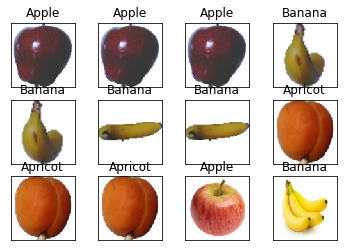

Activation function : tanh
Epoch 1/15
272/272 [==============================] - 90s 329ms/step - loss: 0.8943 - acc: 0.7153 - val_loss: 0.8843 - val_acc: 0.7576
Epoch 2/15
272/272 [==============================] - 104s 381ms/step - loss: 0.2598 - acc: 0.9118 - val_loss: 0.2658 - val_acc: 0.9114
Epoch 3/15
272/272 [==============================] - 95s 348ms/step - loss: 0.1626 - acc: 0.9449 - val_loss: 0.2052 - val_acc: 0.9492
Epoch 4/15
272/272 [==============================] - 89s 326ms/step - loss: 0.1014 - acc: 0.9701 - val_loss: 0.7361 - val_acc: 0.7534
Epoch 5/15
272/272 [==============================] - 104s 382ms/step - loss: 0.0677 - acc: 0.9773 - val_loss: 0.1972 - val_acc: 0.9409
Epoch 6/15
272/272 [==============================] - 99s 364ms/step - loss: 0.0744 - acc: 0.9763 - val_loss: 0.2143 - val_acc: 0.9354
Epoch 7/15
272/272 [==============================] - 103s 379ms/step - loss: 0.0517 - acc: 0.9849 - val_loss: 0.1696 - val_acc: 0.9444
Epoch 8/15
272/272 [=====

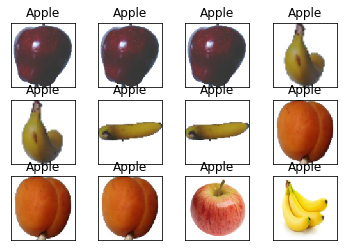

Activation function : sigmoid
Epoch 1/15
272/272 [==============================] - 112s 413ms/step - loss: 2.3667 - acc: 0.1160 - val_loss: 2.1504 - val_acc: 0.2644
Epoch 2/15
272/272 [==============================] - 138s 506ms/step - loss: 1.5755 - acc: 0.4157 - val_loss: 1.2323 - val_acc: 0.6044
Epoch 3/15
272/272 [==============================] - 136s 499ms/step - loss: 1.0612 - acc: 0.6208 - val_loss: 0.9525 - val_acc: 0.6834
Epoch 4/15
272/272 [==============================] - 132s 486ms/step - loss: 0.8255 - acc: 0.6999 - val_loss: 0.8895 - val_acc: 0.6662
Epoch 5/15
272/272 [==============================] - 130s 478ms/step - loss: 0.6606 - acc: 0.7610 - val_loss: 0.8724 - val_acc: 0.6951
Epoch 6/15
272/272 [==============================] - 133s 489ms/step - loss: 0.5330 - acc: 0.8034 - val_loss: 0.8040 - val_acc: 0.7328
Epoch 7/15
272/272 [==============================] - 131s 482ms/step - loss: 0.4573 - acc: 0.8335 - val_loss: 0.7421 - val_acc: 0.7768
Epoch 8/15
272/272

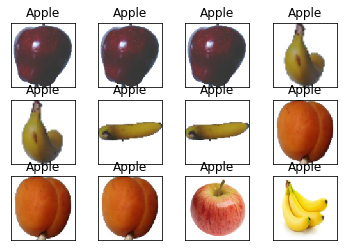

In [7]:
activation = ['relu', 'tanh', 'sigmoid']

for act in activation:
    print("Activation function : " + act)
    model = createModel(act,'categorical_crossentropy','rmsprop')
    model_fit(15)
    testModel()

From the above results, we can see that with <b> <u>ReLU</u> </b> gives the accuracy of <b>99.93%</b> and classifies the images correctly. In case of <b><u>tanh</u></b> activation function we can see that the accuracy is <b>98.70%</b> which is comparatively lesser than ReLU activation function. Also with <b><u>sigmoid</u></b> activation function the accuracy achieved is <b>78.64%</b> which is very less when compared to ReLU activation function.

Now, we know that <b><u>ReLU</u></b> activation function gives us the higher accuracy. We will now train the model for different optimizer function and identify which optimizer gives us the higher accuracy

Optimizer : sgd
Epoch 1/15
272/272 [==============================] - 128s 471ms/step - loss: 1.6798 - acc: 0.3658 - val_loss: 1.0790 - val_acc: 0.7191
Epoch 2/15
272/272 [==============================] - 127s 467ms/step - loss: 0.9737 - acc: 0.6492 - val_loss: 0.6669 - val_acc: 0.8070
Epoch 3/15
272/272 [==============================] - 127s 468ms/step - loss: 0.6298 - acc: 0.7763 - val_loss: 0.4897 - val_acc: 0.8111
Epoch 4/15
272/272 [==============================] - 127s 466ms/step - loss: 0.4590 - acc: 0.8416 - val_loss: 0.3960 - val_acc: 0.8345
Epoch 5/15
272/272 [==============================] - 134s 494ms/step - loss: 0.3453 - acc: 0.8761 - val_loss: 0.3137 - val_acc: 0.8613
Epoch 6/15
272/272 [==============================] - 138s 508ms/step - loss: 0.2770 - acc: 0.9033 - val_loss: 0.2818 - val_acc: 0.8887
Epoch 7/15
272/272 [==============================] - 138s 507ms/step - loss: 0.1995 - acc: 0.9231 - val_loss: 0.3514 - val_acc: 0.8434
Epoch 8/15
272/272 [============

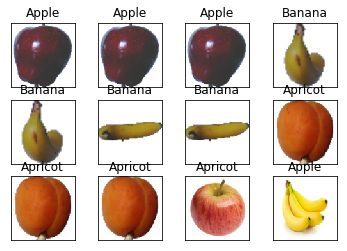

Optimizer : rmsprop
Epoch 1/15
272/272 [==============================] - 141s 519ms/step - loss: 1.0012 - acc: 0.6314 - val_loss: 0.3726 - val_acc: 0.8743
Epoch 2/15
272/272 [==============================] - 140s 513ms/step - loss: 0.2760 - acc: 0.9040 - val_loss: 0.1541 - val_acc: 0.9341
Epoch 3/15
272/272 [==============================] - 142s 521ms/step - loss: 0.1552 - acc: 0.9517 - val_loss: 0.3663 - val_acc: 0.8544
Epoch 4/15
272/272 [==============================] - 140s 514ms/step - loss: 0.1119 - acc: 0.9674 - val_loss: 0.0614 - val_acc: 0.9705
Epoch 5/15
272/272 [==============================] - 140s 515ms/step - loss: 0.1014 - acc: 0.9782 - val_loss: 0.0419 - val_acc: 0.9870
Epoch 6/15
272/272 [==============================] - 140s 514ms/step - loss: 0.0709 - acc: 0.9818 - val_loss: 0.0343 - val_acc: 0.9821
Epoch 7/15
272/272 [==============================] - 138s 508ms/step - loss: 0.0694 - acc: 0.9821 - val_loss: 0.0274 - val_acc: 0.9897
Epoch 8/15
272/272 [========

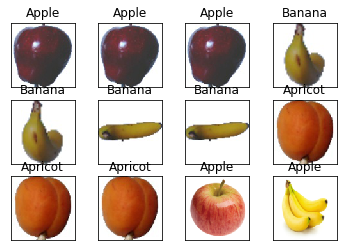

Optimizer : adam
Epoch 1/15
272/272 [==============================] - 137s 505ms/step - loss: 1.0923 - acc: 0.5949 - val_loss: 0.3309 - val_acc: 0.8874
Epoch 2/15
272/272 [==============================] - 136s 500ms/step - loss: 0.2662 - acc: 0.9046 - val_loss: 0.1435 - val_acc: 0.9554
Epoch 3/15
272/272 [==============================] - 136s 499ms/step - loss: 0.1585 - acc: 0.9447 - val_loss: 0.1142 - val_acc: 0.9499
Epoch 4/15
272/272 [==============================] - 136s 500ms/step - loss: 0.0887 - acc: 0.9699 - val_loss: 0.2534 - val_acc: 0.9348
Epoch 5/15
272/272 [==============================] - 136s 500ms/step - loss: 0.1558 - acc: 0.9508 - val_loss: 0.1139 - val_acc: 0.9519
Epoch 6/15
272/272 [==============================] - 136s 501ms/step - loss: 0.0653 - acc: 0.9768 - val_loss: 0.0466 - val_acc: 0.9842
Epoch 7/15
272/272 [==============================] - 138s 507ms/step - loss: 0.0715 - acc: 0.9752 - val_loss: 0.0328 - val_acc: 0.9863
Epoch 8/15
272/272 [===========

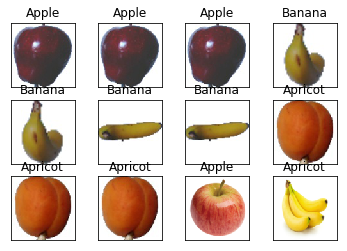

In [9]:
optimizer = ['sgd', 'rmsprop', 'adam']

for opt in optimizer:
    print("Optimizer : " + opt)
    model = createModel('relu','categorical_crossentropy',opt)
    model_fit(15)
    testModel()

Now, we know <b>ReLU</b> activation function and <b>rmsprop</b> optimizer gives us the higher accuracy. We will now train the model for different numbers of epochs and identify number of epochs that gives us the higher accuracy

No of Epochs : 10
Epoch 1/10
272/272 [==============================] - 90s 331ms/step - loss: 0.8766 - acc: 0.6843 - val_loss: 0.4161 - val_acc: 0.8503
Epoch 2/10
272/272 [==============================] - 88s 324ms/step - loss: 0.2527 - acc: 0.9216 - val_loss: 0.1373 - val_acc: 0.9354
Epoch 3/10
272/272 [==============================] - 88s 324ms/step - loss: 0.1645 - acc: 0.9546 - val_loss: 0.1790 - val_acc: 0.9093
Epoch 4/10
272/272 [==============================] - 88s 324ms/step - loss: 0.1035 - acc: 0.9713 - val_loss: 0.0390 - val_acc: 0.9876
Epoch 5/10
272/272 [==============================] - 94s 345ms/step - loss: 0.0781 - acc: 0.9818 - val_loss: 0.0398 - val_acc: 0.9835
Epoch 6/10
272/272 [==============================] - 96s 354ms/step - loss: 0.0758 - acc: 0.9793 - val_loss: 0.3169 - val_acc: 0.8935
Epoch 7/10
272/272 [==============================] - 101s 371ms/step - loss: 0.0871 - acc: 0.9814 - val_loss: 0.0870 - val_acc: 0.9712
Epoch 8/10
272/272 [================

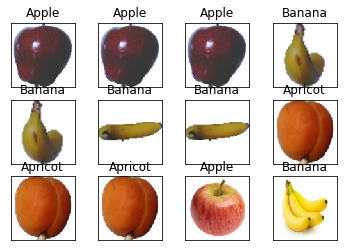

No of Epochs : 15
Epoch 1/15
272/272 [==============================] - 86s 315ms/step - loss: 0.9486 - acc: 0.6543 - val_loss: 0.3062 - val_acc: 0.9354
Epoch 2/15
272/272 [==============================] - 92s 340ms/step - loss: 0.2496 - acc: 0.9175 - val_loss: 0.2321 - val_acc: 0.9492
Epoch 3/15
272/272 [==============================] - 90s 331ms/step - loss: 0.1493 - acc: 0.9569 - val_loss: 0.0685 - val_acc: 0.9746
Epoch 4/15
272/272 [==============================] - 103s 377ms/step - loss: 0.1083 - acc: 0.9685 - val_loss: 0.0443 - val_acc: 0.9780
Epoch 5/15
272/272 [==============================] - 101s 372ms/step - loss: 0.1090 - acc: 0.9750 - val_loss: 0.0379 - val_acc: 0.9794
Epoch 6/15
272/272 [==============================] - 91s 333ms/step - loss: 0.0763 - acc: 0.9786 - val_loss: 0.0991 - val_acc: 0.9382
Epoch 7/15
272/272 [==============================] - 94s 347ms/step - loss: 0.0812 - acc: 0.9825 - val_loss: 0.0614 - val_acc: 0.9746
Epoch 8/15
272/272 [===============

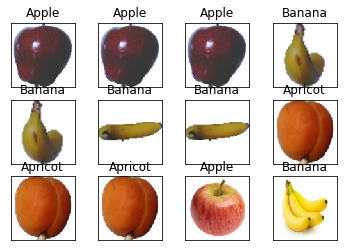

No of Epochs : 20
Epoch 1/20
272/272 [==============================] - 93s 340ms/step - loss: 0.9814 - acc: 0.6535 - val_loss: 0.4165 - val_acc: 0.8455
Epoch 2/20
272/272 [==============================] - 92s 340ms/step - loss: 0.2694 - acc: 0.9141 - val_loss: 0.3407 - val_acc: 0.9203
Epoch 3/20
272/272 [==============================] - 98s 358ms/step - loss: 0.1563 - acc: 0.9543 - val_loss: 0.2879 - val_acc: 0.9210
Epoch 4/20
272/272 [==============================] - 102s 374ms/step - loss: 0.1196 - acc: 0.9670 - val_loss: 0.2059 - val_acc: 0.9423
Epoch 5/20
272/272 [==============================] - 93s 341ms/step - loss: 0.0974 - acc: 0.9738 - val_loss: 0.1631 - val_acc: 0.9471
Epoch 6/20
272/272 [==============================] - 98s 358ms/step - loss: 0.0798 - acc: 0.9784 - val_loss: 0.0175 - val_acc: 0.9924
Epoch 7/20
272/272 [==============================] - 97s 358ms/step - loss: 0.0590 - acc: 0.9830 - val_loss: 0.5875 - val_acc: 0.8935
Epoch 8/20
272/272 [================

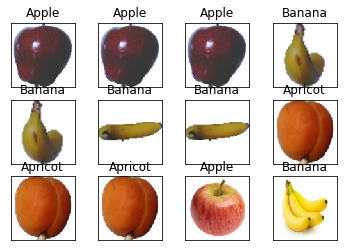

In [10]:
epoch = [10, 15, 20]

for e in epoch:
    print("No of Epochs : " + str(e))
    model = createModel('relu','categorical_crossentropy','rmsprop')
    model_fit(e)
    testModel()

From the results that we got after hyperparameter tunning we can see that the best parameters for creating a model with higher accuracy is :

1. Activation Function : <b>ReLU</b>
2. Optimizer : <b>rmsprop</b>
3. Number of Epochs : <b> </b>

As our dataset is relatively small , we are chosing the number of epochs as . This varies as per the size of the dataset. Therefore before deciding on the number of epochs and other parameters, we do the hyper parameter tunning to find the best set of parameters

Now that we understand how to create and train the model using Convolutional Neural Network and chose the correct parameters for creating the model, in the next section we explain the process to do Object Detection using transfer learning.

## Object Detection

TensorFlow’s Object Detection API is a powerful tool that makes it easy to construct, train, and deploy object detection models. In most of the cases, training an entire convolutional network from scratch is time consuming and requires large datasets. This problem can be solved by using the advantage of transfer learning with a pre-trained model using the TensorFlow API. Before getting into the technical details of implementing the API, let’s discuss the concept of transfer learning.

Transfer learning is a research problem in machine learning that focuses on storing the knowledge gained from solving one problem and applying it to a different but related problem.

We will be using COCO pre-trained model/checkpoints RFCN resnet for our transfer learning. 

## Installation Instructions

Tensorflow object detection API depends upon the following library:
-  Protobuf 3.4.0
-  Python
-  Pillow 1.0
-  lxml
-  tf Slim (which is included in the "tensorflow/models/research/")
-  Jupyter notebook
-  Matplotlib
-  Tensorflow
-  Cython

First clone or download the github of tensorflow,

<i>git clone https://github.com/tensorflow/models.git<i>

Next, run the command

<i> pip install tensorflow </i>

in your terminal window. If you have tensorflow already installed, upgrade it to the latest version. For upgarding tensorflow version, run the command

<i> pip install tensorflow --upgrade </i>

in your terminal window. Now install all the dependent libraries by running

<i>pip install Cython</i>

<i>pip install jupyter</i>

<i>pip install matplotlib</i>

<h3> For Protobuf Compilation </h3>

-  Download the protobuf 4.0 executable from [here](https://github.com/google/protobuf/releases)
-  Unzip the file and copy protoc.exe from /protoc/bin folder and copy it to models/research folder
-  Navigate to /models/research folder on the terminal widow and execute

<i> protoc object_detection/protos/*.proto --python_out=. </i>

-  Set the environment variable PYTHONPATH and set the value as the path to the research folder and also the path till slim folder (which is inside models/research/slim folder inside tensorflow github)

<h3> Testing the installation </h3>

we can test that we have correctly installed the Tensorflow Object Detection API by running the following command: 

<i> python object_detection/builders/model_builder_test.py </i>

<h3> Dataset Labels </h3>

Tensorflow Object detection API requires all the training images be labelled and in the TFRecord format.

For labelling images , follow the below instructions:
-  Git clone https://github.com/tzutalin/labelImg
-  Before starting with the annotation of images, the classes for labelling needs to be defined in the LabelImg/data/predefined_classes.txt file. 
-  Launch labelimg.exe and then select the dataset folder by clicking the OpenDir icon on the left pane.
-  For each image that appears, draw a rectangular box across each grocery item by clicking the Create RectBox icon. These rectangular boxes are known as bounding boxes. Select the category as defined in predefined_classes.txt  from the drop-down list that appears.
-  Repeat this process for every object present in the image. Figure below shows an example of a completely annotated image

Once the annotations for an image are completed, save the image to any folder.

The corresponding eXtensible Markup Language (XML) files will be generated for each image in the specified folder. XML files contain the coordinates of the bounding boxes, filename, category, and so on for each object within the image. These annotations are the ground truth boxes for comparison.


<h4> Creating TFRecords from labelled images </h4>

Tensorflow object detection API accepts input in particular format called TFRecord file which is a simple record-oriented binary format. To create TFRecord we first have to create the csv file from the xml files generated for images and then create TFRecord. To do this we exceute <b>generate_tfrecord.py </b> and <b>xml_to_csv.py</b> which are kept the root location.

-  for creating csv file execute:

<i>python xml_to_csv.py</i>

from your terminal window. This command will generate train_labels.csv and test_labels.csv file.

-  for creating TFRecord exceute,

<i> python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=data/train.record </i> , this creates TFRecord for train data

<i> python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=data/test.record </i> , this creates TFRecord for test data

<h3> Model Config File </h3>

Now, we will modify the model's config file to train it to the number of classes in our dataset. After you have cloned the tensorflow models github, navigate to /research/object_detection/configs folder in your terminal window. In this folder you will find config files for all of the pre-trained models.

Create a folder with name training inside research folder and copy config file of the rfcn pre trained model inside research folder. Open the config file and change <b>num_classes</b> to the number of classes in your dataset.

Next you need to change the input_path and label_map_path for both the training and evaluation dataset. Input_path just goes to your TFRecord file. Before we can set the path for label_map_path we need to create the file it’s supposed to point to. All it’s looking for is a .pbtxt file that contains the id and name for each of the labels of your dataset. You can create this in any text file by following the format below.
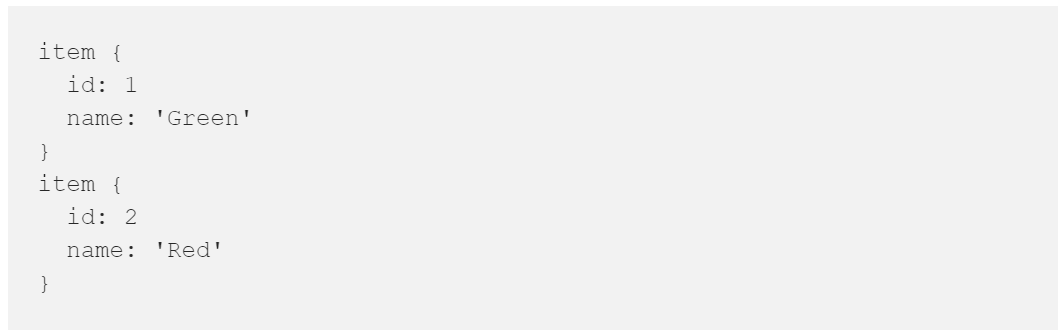

Ensure you start with id: 1 and not 0. Place this file inside training folder

Navigate to the object_detection folder and copy train.py to research folder. To begin training simply navigate your terminal window to research folder and enter in the command line,

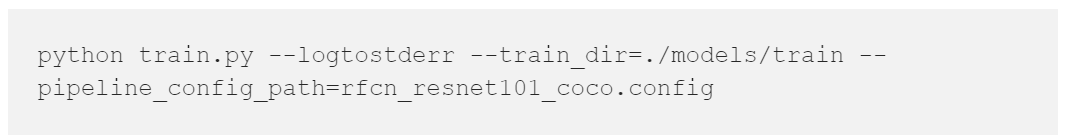

where pipline_config_path points to your config file. Training will now begin. Beware that depending on your system, training could take a few minutes to start so if it doesn’t crash or stop, give it some more time.

At this point in the tutorial you have selected a pre-trained object detection model, adapted an existing dataset or created your own and turned it into a TFRecord file, modified a model config file, and started training.

Inside the research/training folder we can see that .ckpt file is created. 

Navigate back to your TensorFlow object detection folder and copy the export_inference_graph.py file into the research folder and run the below command.

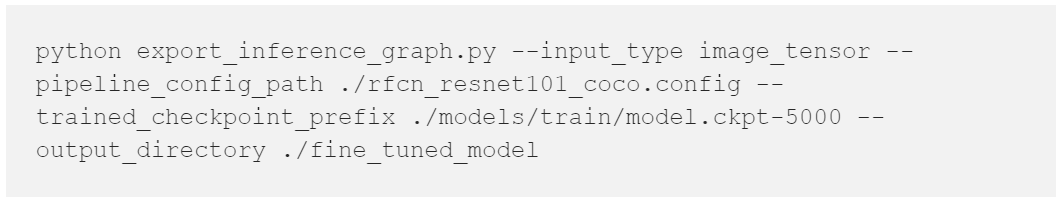

In the above command, output_directory is the name of the output folder where your frozen file would be created.

Now, we will run the below commands to test the model on test images

In [11]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

In [12]:
# This is needed to display the images.
%matplotlib inline

In [13]:
from utils import label_map_util

from utils import visualization_utils as vis_util

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<h3>Variables</h3>

Any model exported using the export_inference_graph.py tool can be loaded here simply by changing PATH_TO_CKPT to point to a new .pb file.


In [14]:
# What model to download.
MODEL_NAME = 'groceryIdentfication'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

NUM_CLASSES = 3

### Load a (frozen) Tensorflow model into memory.

In [15]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

NotFoundError: NewRandomAccessFile failed to Create/Open: groceryIdentfication/frozen_inference_graph.pb : The system cannot find the path specified.
; No such process

<h3>Loading label map</h3>

Label maps map indices to category names, so that when our convolution network predicts 2, we know that this corresponds to Red. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [16]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

NotFoundError: NewRandomAccessFile failed to Create/Open: training\object-detection.pbtxt : The system cannot find the path specified.
; No such process

### Helper code

In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

### Detection

In [ ]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'img{}.jpg'.format(i)) for i in range(1, 5) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

Above results shows how well model is performing on our dataset.